# Bokeh dashboards using Quandl datasets

Though I am not from financial industry, I can understand the impact that precious commodities have on stock markets. So I started looking into commodity datasets available for creating useful charts/dashboard. One of my colleague told me about
[Quandl](https://www.quandl.com/) which has datasets realted to finance and economy targeting investment professional.

## How Quandl works

You need to sign up for Quandl [account](https://www.quandl.com/sign-up-modal?defaultModal=showSignUp) which allows you to download free data and samples of premium data. Once you have signed up, you will be provided with API key and you can find the API key under account settings. To know more about API limits for a free account click [here](https://docs.quandl.com/docs/getting-started)

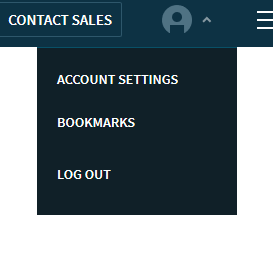

You can use Quandl API in R, Python and through Excel plugin. I went for Python as Quandl has a package that you can install using pip. I won't go into the details as it is well [documented](https://docs.quandl.com/docs/python-installation) by quandl's team.



## Data Processing

### main.py
---

Data can be accessed by calling the quandl api using the following code:

```python
quandl.ApiConfig.api_key = "GIVE YOUR API KEY HERE"
```

Once you have set the api key you can quandl datatables using .get method

```python
data1 = quandl.get("LBMA/SILVER", collapse="monthly")
data2 = quandl.get("LBMA/GOLD", collapse="monthly")
```

Importing tab_commodity() function from commodity_select.py 

```python
from scripts.commodity_select import tab_commodity
```
We will be doing a bit a data processing to make sure data is consistent across commodities. Some data processing steps performed are

* Convert the output from quandl api get call into pandas dataframe

```python
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
```

* Fill NA values with 0

```python
df1 = df1.fillna(0)
df2 = df2.fillna(0)
```

* Resetting the index on the dataframe

```python
df1 = df1.reset_index()
df2 = df2.reset_index()
```
* Converting the Date column to datetime object

```python
df1['Date'] = pd.to_datetime(df1['Date'])
df1['Date'] = pd.DatetimeIndex(df1['Date'])

df2['Date'] = pd.to_datetime(df2['Date'])
df2['Date'] = pd.DatetimeIndex(df2['Date'])
```
* Selecting a subset of dataframe

```python
df1 = df1[['Date','USD']]
df2 = df2[['Date','USD (PM)']]
```
* Renaming the column in df2 and assigning new column to each dataframe

```python
df2.rename(columns={'USD (PM)': 'USD'}, inplace=True)
df1['Commodity']='SILVER'
df2['Commodity']='GOLD'
```

* Combining the dataframes

```python
frames = [df1,df2]
df_commodity = pd.concat(frames)
```
Also lets create a list of commodities that will be passed to the function in *commodity_select.py*

tab2 = tab_commodity(commodities,df_commodity)

## Tab1 - Precious Commodities

### commodity_select.py
---

Here is the commodity_select.py which is used to created *Commodity Trend* tab.

First step is to import the libraries required for passing data to the plot and dropdown select

```python
import pandas as pd
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Select, Panel, HoverTool
from bokeh.plotting import figure
```

Now lets define the function *tab_commodity* that will be called from main.py

```python

def tab_commodity(commodities, df_commodity):
    p = figure(plot_width=960, plot_height=540, title="Commodity Trend",x_axis_type="datetime",sizing_mode="scale_width")
    p.background_fill_color="#f5f5f5"
    p.background_fill_alpha = 0.5
    p.grid.grid_line_color="white"
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Value in USD'
    p.axis.axis_line_color = None
    
    hover = HoverTool()
    
    select_commodity = Select(title='Commodity:',value=commodities[0],options=commodities)
    x_val = df_commodity.loc[df_commodity['Commodity'] == select_commodity.value].Date.tolist()
    y_val = df_commodity.loc[df_commodity['Commodity'] == select_commodity.value].USD.tolist()
    source = ColumnDataSource(data=(dict(x=x_val,y=y_val)))
    
    p.line('x','y',source=source,color='#ebbd5b',alpha=0.5,line_width=2)
           
    hover.tooltips = [("Date", "@x{%F}"),("Value", "$@{y}")]
    hover.formatters={
        'x' : 'datetime'
        }
    hover.mode = 'vline'
    p.tools.append(hover)
    
    def callback(attr,old,new):
        new_commodity = select_commodity.value
        x_new = df_commodity.loc[df_commodity['Commodity'] == new_commodity].Date.tolist()
        y_new = df_commodity.loc[df_commodity['Commodity'] == new_commodity].USD.tolist()
        source_new = ColumnDataSource(data=(dict(x=x_new,y=y_new)))
        source.data = source_new.data
    
    select_commodity.on_change('value',callback)
    layout = column(select_commodity,p)
    tab2 = Panel(child = layout, title = 'Commodity Performance')
    
    return tab2
    
```

## Tab2 - Stocks

### main.py

Quandl has data on stocks which can be used to create dashboards that are useful for financial institutions. To get the data from quandl, we are going to use *get_table* method. Below is the code block for doing it

```python
from scripts.Stocks_Select import stock_tab

tickerlist = ['AAPL','IBM','MSFT','GOOG']

df = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker','date', 'close'] }, 
                       ticker = tickerlist, date = { 'gte': '2016-01-01', 'lte': '2016-12-31' })
```

```python
df = df[['ticker','date','close']]
df['date'] = pd.DatetimeIndex(df['date'])
```

Calling the *stock_tab* function from *Stocks_Select.py*

```python
tab1 = stock_tab(tickerlist, df)
```

### Stocks_Select.py
---

```python

import pandas as pd
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Select, Panel, HoverTool
from bokeh.plotting import figure

def stock_tab(tickerlist, df):
    p = figure(plot_width=960, plot_height=540, x_axis_type="datetime",sizing_mode="scale_width")
    p.background_fill_color="#f5f5f5"
    p.background_fill_alpha = 0.5
    p.grid.grid_line_color="white"
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Value in USD'
    p.axis.axis_line_color = None
    
    hover = HoverTool()
    hover.tooltips = [("Date", "@x{%F}"),("Value", "$@{y}")]
    hover.formatters={'x':'datetime'}
    hover.mode = 'vline'
    p.tools.append(hover)
    
    def callback(attr,old,new):
        ticker_new = ticker.value
        x = df.loc[df['ticker'] == ticker_new].date.tolist()
        y = df.loc[df['ticker'] == ticker_new].close.tolist()
        source_new = ColumnDataSource(data=dict(x=x,y=y))
        source.data = source_new.data
        ticker.value = ticker_new
    
    ticker = Select(title="Ticker:",value=tickerlist[0],options=tickerlist)
    x = df.loc[df['ticker'] == ticker.value].date.tolist()
    y = df.loc[df['ticker'] == ticker.value].close.tolist()
    ticker.on_change('value',callback)
    source = ColumnDataSource(data=dict(x=x, y=y))
    p.line('x','y', line_width=2, color='navy', alpha=0.5,source=source)
    layout = column(ticker, p)
    tab = Panel(child = layout, title = 'Stock Performance')
    return tab

```

### Final steps

Combine tab1 and tab2

```python
tabs = Tabs(tabs = [tab1,tab2])
```

Pass tabs to curdoc

```python
curdoc().add_root(tabs)
```

All the code blocks above should be added to *main.py*

The final output looks like

In [17]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/jj_GTBJcNr0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope" allowfullscreen></iframe>')